In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

style.use('ggplot')

# Read data
stockFile = 'DJI.csv'
stock = pd.read_csv(stockFile, index_col=0, parse_dates=[0])
print('Shape of data', stock.shape)
stock.head(10)


Shape of data (5127, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,11501.849609,11522.009766,11305.690430,11357.509766,11357.509766,169750000
2000-01-04,11349.750000,11350.059570,10986.450195,10997.929688,10997.929688,178420000
2000-01-05,10989.370117,11215.099609,10938.669922,11122.650391,11122.650391,203190000
2000-01-06,11113.370117,11313.450195,11098.450195,11253.259766,11253.259766,176550000
2000-01-07,11247.059570,11528.139648,11239.919922,11522.559570,11522.559570,184900000
2000-01-10,11532.480469,11638.280273,11532.480469,11572.200195,11572.200195,168180000
2000-01-11,11568.469727,11663.099609,11502.700195,11511.080078,11511.080078,177300000
2000-01-12,11506.730469,11612.530273,11505.179688,11551.099609,11551.099609,194060000
2000-01-13,11558.240234,11656.580078,11524.110352,11582.429688,11582.429688,174910000


In [2]:
# Resample to weely time series
stock_week = stock['Close'].resample('W-MON').mean()
stock_week.head()
                                    

Date
2000-01-03    11357.509766
2000-01-10    11293.719922
2000-01-17    11591.897461
2000-01-24    11332.251953
2000-01-31    10954.059961
Freq: W-MON, Name: Close, dtype: float64

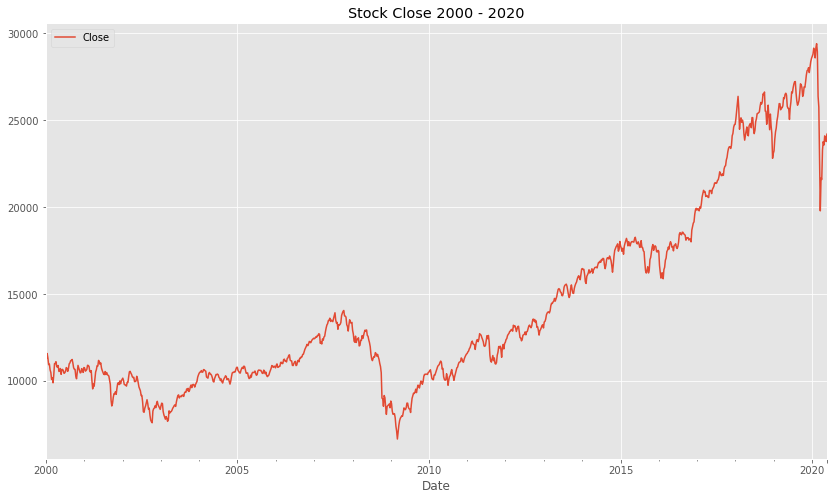

In [3]:
# Trend of Stock Close
stock_week.plot(figsize=(14,8))
plt.title('Stock Close 2000 - 2020')
plt.legend()
sns.despine()

In [4]:
# Spilt training and test datasets

num = len(stock_week)
print(num)

1065


In [5]:
train = stock_week[:800]
test = stock_week[800:900]
print(test)

Date
2015-05-04    18016.130078
2015-05-11    17998.103906
2015-05-18    18190.480469
2015-05-25    18278.887695
2015-06-01    18076.339453
                  ...     
2017-02-27    20797.623828
2017-03-06    20978.162500
2017-03-13    20884.628125
2017-03-20    20908.499609
2017-03-27    20626.718359
Freq: W-MON, Name: Close, Length: 100, dtype: float64


In [6]:
# Stationarity check
# If P-value > 0.05, then data will be differenced

from statsmodels.tsa.stattools import adfuller
from numpy import log
adftest = adfuller(train.dropna())
print('p-value: %f' % adftest[1])

p-value: 0.943065


p-value: 0.000000


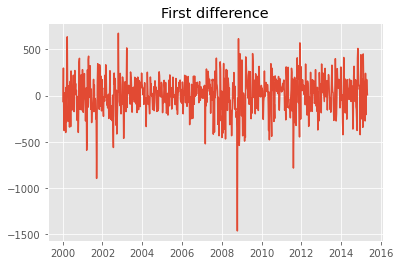

In [7]:
# First difference
stock_diff = train.diff()
stock_diff = stock_diff.dropna()

adftest_1 = adfuller(stock_diff.dropna())
print('p-value: %f' % adftest_1[1])

plt.figure()
plt.plot(stock_diff)
plt.title('First difference')
plt.show()

First difference looks good enough

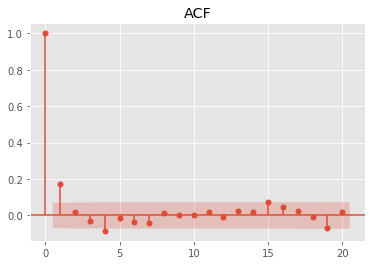

In [8]:
# ACF
acf = plot_acf(stock_diff, lags = 20)
plt.title('ACF')
acf.show()

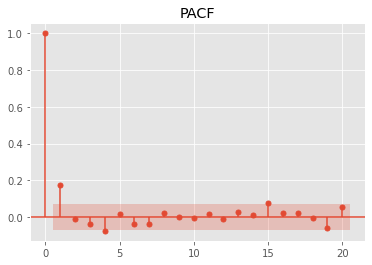

In [9]:
# PACF
pacf = plot_pacf(stock_diff, lags = 20)
plt.title('PACF')
pacf.show()

From ACF and Pacf,  p can be 1,2; q can be 1,2

In [23]:
# Figure out order for ARIMA model 
from pmdarima import auto_arima
stepwise_fit = auto_arima(train, trace=True, suppress_warnings=True)
stepwise_fit.summary()

ImportError: cannot import name '_centered' from 'scipy.signal.signaltools' (D:\anaconda\lib\site-packages\scipy\signal\signaltools.py)

Build model by order(1,1,0)

In [10]:
# Build ARIMAX
model = ARIMA(train, order=(1,1,1))
model = model.fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  799
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5363.237
Method:                       css-mle   S.D. of innovations            199.035
Date:                Wed, 23 Feb 2022   AIC                          10734.474
Time:                        00:16:17   BIC                          10753.207
Sample:                    01-10-2000   HQIC                         10741.671
                         - 04-27-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.3326      8.453      0.986      0.324      -8.236      24.901
ar.L1.D.Close     0.1216      0.179      0.678      0.498      -0.230       0.473
ma.L1.D.Close     0.0548      0.180     

In [17]:
# Make predictions on test dataset
start = len(train)
end = len(train)+99
pred = model.predict(start=start, end=end, typ='levels')
print(pred)

2015-05-04    18041.002986
2015-05-11    18049.303743
2015-05-18    18057.632436
2015-05-25    18065.964525
2015-06-01    18074.297027
                  ...     
2017-02-27    18832.559885
2017-03-06    18840.892444
2017-03-13    18849.225003
2017-03-20    18857.557562
2017-03-27    18865.890121
Freq: W-MON, Length: 100, dtype: float64


Text(0.5, 1.0, 'Acutal vs. Fitted')

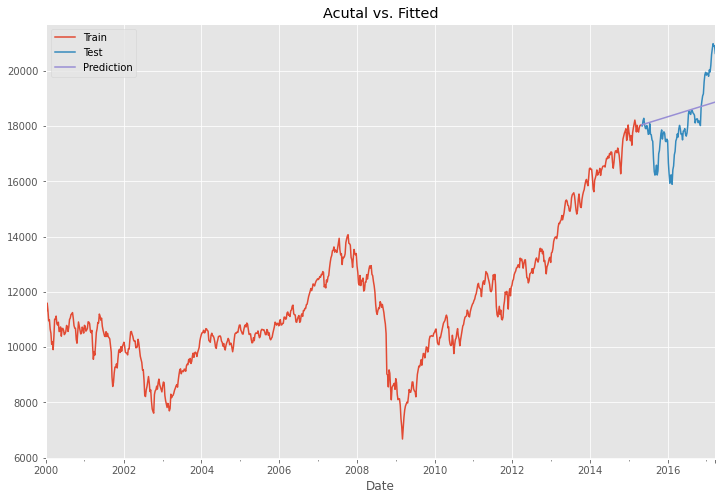

In [18]:
# Acutal vs. Fitted
train.plot(legend=True, label='Train', figsize=(12,8))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction')
plt.title('Acutal vs. Fitted')

In [19]:
#Evaluate model by MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, pred)
print(mae)

878.5914444665053
